In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.stats as stats
from matplotlib import cm
from scipy import interpolate

%matplotlib inline
plt.rcParams["figure.figsize"] = (7, 5) # (w, h)

def rmse(arr_1, arr_2, axis=None):
    mask = np.logical_and(~np.isnan(arr_1), ~np.isnan(arr_2))
    return np.sqrt(np.mean(np.square(arr_1[mask] - arr_2[mask]), axis=axis))

# Simplified Example

In [2]:
truth = np.ones((5, 6))

# Flight lines are stacked column-wise:
flight_lines = np.array([[1, 0, 1, 0, 1, 0],
                         [1, 0, 1, 0, 1, 0],
                         [1, 0, 1, 0, 1, 0],
                         [1, 0, 1, 0, 1, 0],
                         [1, 0, 1, 0, 1, 0]])

lats = np.array([[0, 0, 0, 0, 0, 0],
                 [1, 1, 1, 1, 1, 1],
                 [2, 2, 2, 2, 2, 2],
                 [3, 3, 3, 3, 3, 3],
                 [4, 4, 4, 4, 4, 4]])
    
lons = np.array([[0, 1, 2, 3, 4, 5],
                 [0, 1, 2, 3, 4, 5],
                 [0, 1, 2, 3, 4, 5],
                 [0, 1, 2, 3, 4, 5],
                 [0, 1, 2, 3, 4, 5]])

tie_lines = np.array([[1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1]])

tie_lats = np.array([[0, 0, 0, 0, 0, 0],
                     [2, 2, 2, 2, 2, 2],
                     [4, 4, 4, 4, 4, 4]])

tie_lons = np.array([[0, 1, 2, 3, 4, 5],
                     [0, 1, 2, 3, 4, 5],
                     [0, 1, 2, 3, 4, 5]])

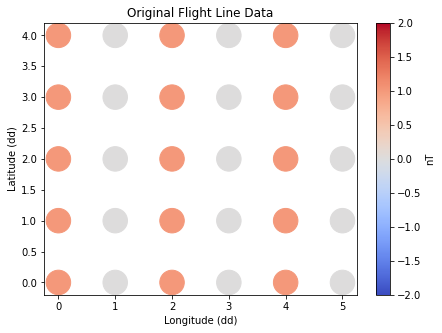

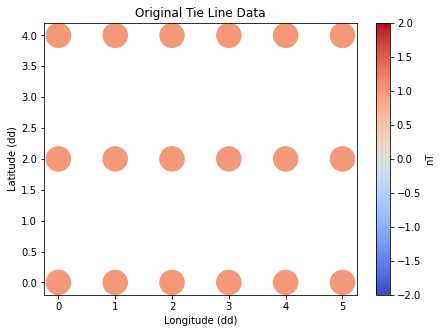

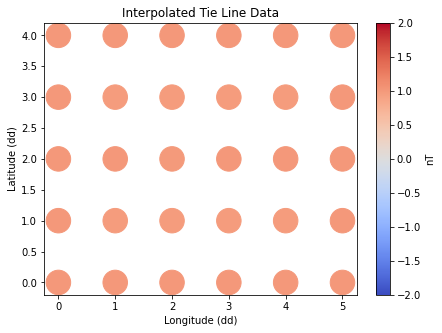

In [3]:
f = interpolate.Rbf(tie_lons.flatten(),
                    tie_lats.flatten(),
                    tie_lines.flatten(),
                    function='linear')
tie_interp = f(lons.flatten(), lats.flatten()).reshape(lats.shape)

plt.figure()
plt.title('Original Flight Line Data')
plt.scatter(lons.flatten(), lats.flatten(), s=600, c=flight_lines.flatten(), cmap=cm.coolwarm)
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.colorbar(label='nT')
plt.clim(-2, 2)

plt.figure()
plt.title('Original Tie Line Data')
plt.scatter(tie_lons.flatten(), tie_lats.flatten(), s=600, c=tie_lines.flatten(), cmap=cm.coolwarm)
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.colorbar(label='nT')
plt.clim(-2, 2)

plt.figure()
plt.title('Interpolated Tie Line Data')
plt.scatter(lons.flatten(), lats.flatten(), s=600, c=tie_interp.flatten(), cmap=cm.coolwarm)
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.colorbar(label='nT')
plt.clim(-2, 2)

plt.show()

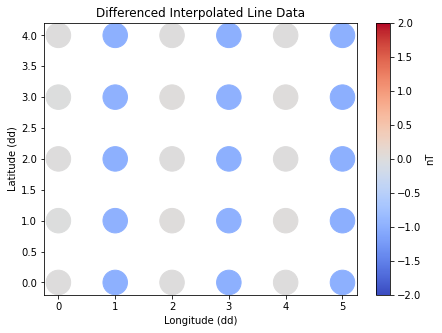

In [4]:
diff = flight_lines - tie_interp

plt.figure()
plt.title('Differenced Interpolated Line Data')
plt.scatter(lons.flatten(), lats.flatten(), s=600, c=diff.flatten(), cmap=cm.coolwarm)
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.colorbar(label='nT')
plt.clim(-2, 2)

# Level flight lines using a 1D linear regression approach

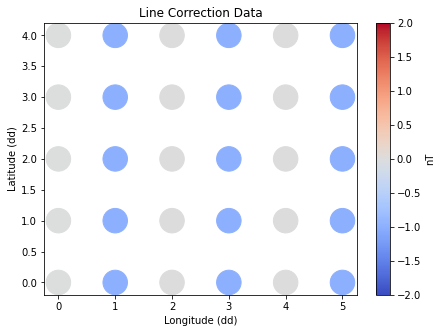

In [5]:
corrections = np.zeros(flight_lines.shape)

for i in range(flight_lines.shape[1]):
    line  = diff[:, i]
    dists = np.arange(len(line))
    res   = stats.linregress(dists, line)
    
    corrections[:, i] = res.intercept + (res.slope * dists)

plt.figure()
plt.title('Line Correction Data')
plt.scatter(lons.flatten(), lats.flatten(), s=600, c=corrections.flatten(), cmap=cm.coolwarm)
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.colorbar(label='nT')
plt.clim(-2, 2)

0.0074033020482891605 nT


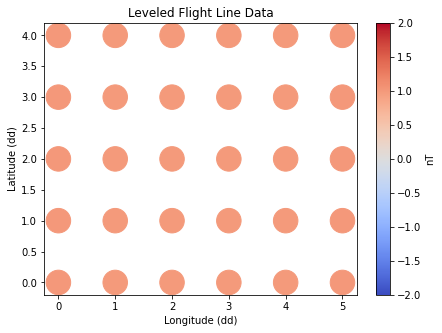

In [6]:
lvld_flight_lines = flight_lines - corrections

plt.figure()
plt.title('Leveled Flight Line Data')
plt.scatter(lons.flatten(), lats.flatten(), s=600, c=lvld_flight_lines.flatten(), cmap=cm.coolwarm)
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.colorbar(label='nT')
plt.clim(-2, 2)

print(rmse(lvld_flight_lines, truth), 'nT')

# Level flight lines using a 2D first order least squares approach

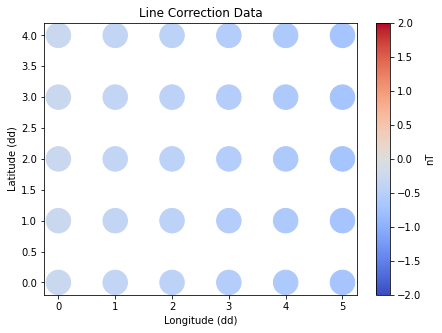

In [7]:
A = np.hstack([lons.flatten()[:, np.newaxis],
               lats.flatten()[:, np.newaxis],
               np.ones((len(lons.flatten()), 1))])
C, _, _, _ = la.lstsq(A, diff.flatten())

corrections = A @ C

plt.figure()
plt.title('Line Correction Data')
plt.scatter(lons.flatten(), lats.flatten(), s=600, c=corrections, cmap=cm.coolwarm)
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.colorbar(label='nT')
plt.clim(-2, 2)

0.4781240273265418 nT


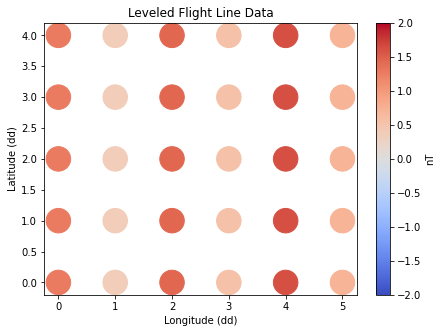

In [8]:
lvld_flight_lines = flight_lines.flatten() - corrections

plt.figure()
plt.title('Leveled Flight Line Data')
plt.scatter(lons.flatten(), lats.flatten(), s=600, c=lvld_flight_lines.flatten(), cmap=cm.coolwarm)
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.colorbar(label='nT')
plt.clim(-2, 2)

print(rmse(lvld_flight_lines.reshape(truth.shape), truth), 'nT')

# Example with Simulated Survey Data

## Setup:

In [9]:
import sys
from copy import deepcopy
from os import getcwd
from os.path import dirname, join

import pandas as pd
import scipy.linalg as la
from matplotlib import cm
from scipy.spatial import distance

SRC_DIR = join(dirname(getcwd()), 'MAMMAL')
sys.path.append(SRC_DIR)
BASE_DIR = dirname(SRC_DIR)
DATA_DIR = join(BASE_DIR, 'data')
TEST_DIR = join(DATA_DIR, 'test')

import MAMMAL.Diurnal as Diurnal
from ppigrf import igrf
from MAMMAL.Utils import coordinateUtils as cu


%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10) # (w, h)
pd.set_option('mode.chained_assignment', None)


REF_FNAME    = join(getcwd(), 'data', 'ref_2019_9_12_0.csv')
SURVEY_FNAME = join(getcwd(), 'data', 'survey_2019_9_12_0.csv')


ref_df    = pd.read_csv(REF_FNAME, parse_dates=['datetime'])
survey_df = pd.read_csv(SURVEY_FNAME, parse_dates=['datetime'])

## Save Truth Data

In [10]:
timestamps = survey_df.loc[survey_df.LINE_TYPE == 1, 'epoch_sec']
lats       = survey_df.loc[survey_df.LINE_TYPE == 1, 'LAT']
lons       = survey_df.loc[survey_df.LINE_TYPE == 1, 'LONG']
heights    = survey_df.loc[survey_df.LINE_TYPE == 1, 'ALT']

tl_timestamps = survey_df.loc[survey_df.LINE_TYPE == 0, 'epoch_sec']
tl_lats       = survey_df.loc[survey_df.LINE_TYPE == 0, 'LAT']
tl_lons       = survey_df.loc[survey_df.LINE_TYPE == 0, 'LONG']
tl_heights    = survey_df.loc[survey_df.LINE_TYPE == 0, 'ALT']

# Find diurnal/space weather effects
_, ref_scalar = Diurnal.interp_reference_df(df            = ref_df,
                                            timestamps    = timestamps,
                                            survey_lon    = None,
                                            ref_scale     = 1,
                                            ref_offset    = 0,
                                            subtract_core = True)

_, tl_ref_scalar = Diurnal.interp_reference_df(df            = ref_df,
                                               timestamps    = tl_timestamps,
                                               survey_lon    = None,
                                               ref_scale     = 1,
                                               ref_offset    = 0,
                                               subtract_core = True)

# Find Earth's Core field
Be, Bn, Bu = igrf(lons,
                  lats,
                  heights / 1000,
                  survey_df.datetime[0])

IGRF = np.hstack((Bn.squeeze()[:, np.newaxis],
                  Be.squeeze()[:, np.newaxis],
                 -Bu.squeeze()[:, np.newaxis]))
IGRF_F = la.norm(IGRF, axis=1)

tl_Be, tl_Bn, tl_Bu = igrf(tl_lons,
                           tl_lats,
                           tl_heights / 1000,
                           survey_df.datetime[0])

tl_IGRF = np.hstack((tl_Bn.squeeze()[:, np.newaxis],
                     tl_Be.squeeze()[:, np.newaxis],
                    -tl_Bu.squeeze()[:, np.newaxis]))
tl_IGRF_F = la.norm(tl_IGRF, axis=1)

# Remove non-anomaly components
survey_df.loc[survey_df.LINE_TYPE == 1, 'F'] -= ref_scalar
survey_df.loc[survey_df.LINE_TYPE == 1, 'F'] -= IGRF_F

survey_df.loc[survey_df.LINE_TYPE == 0, 'F'] -= tl_ref_scalar
survey_df.loc[survey_df.LINE_TYPE == 0, 'F'] -= tl_IGRF_F

# Save truth
truth_fl_scalar = survey_df.loc[survey_df.LINE_TYPE == 1, 'F']

## "Unlevel" the Flight Lines:

In [11]:
unique_fl_nums = np.unique(survey_df.LINE[survey_df.LINE_TYPE == 1])
every_other_unique_fl_num = unique_fl_nums[1::2]

# Add a 10nT offset every other flight line
for line in every_other_unique_fl_num:
    survey_df.loc[np.logical_and(survey_df.LINE == line,
                                 survey_df.LINE_TYPE == 1), 'F'] += 10

## Level the Flight Lines using a 1D linear regression approach:

0.034773508379150095 nT


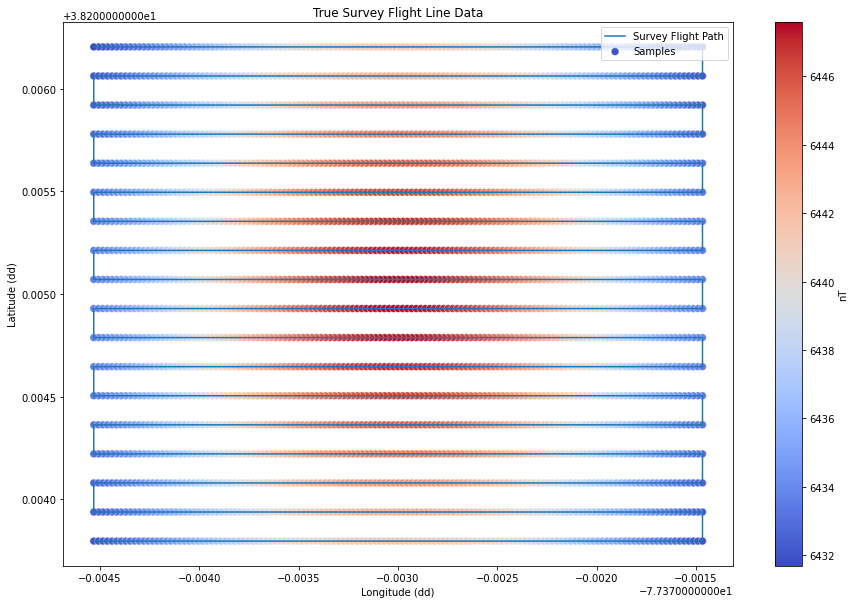

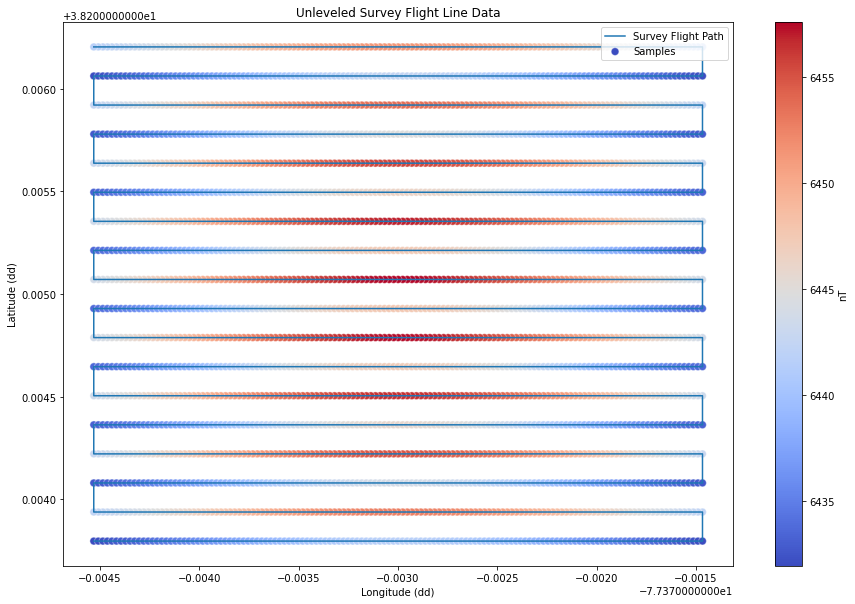

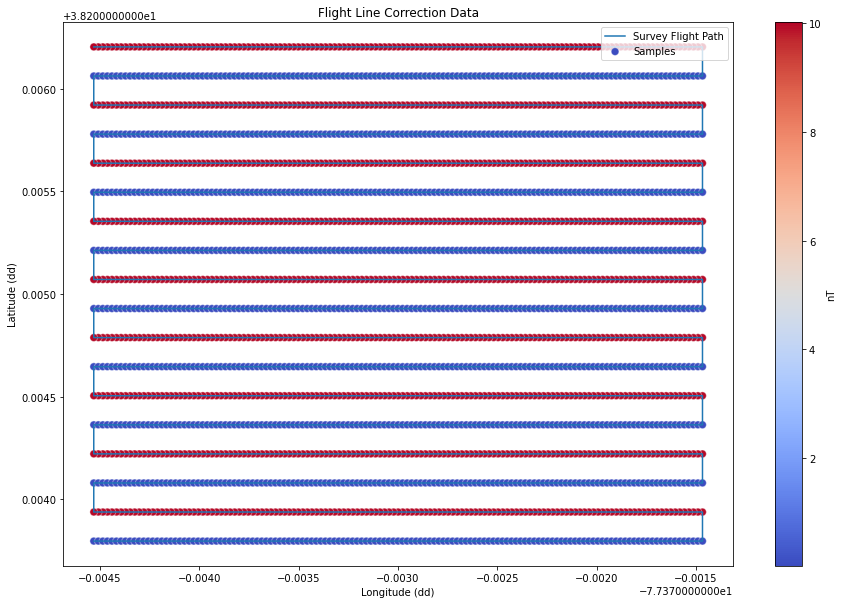

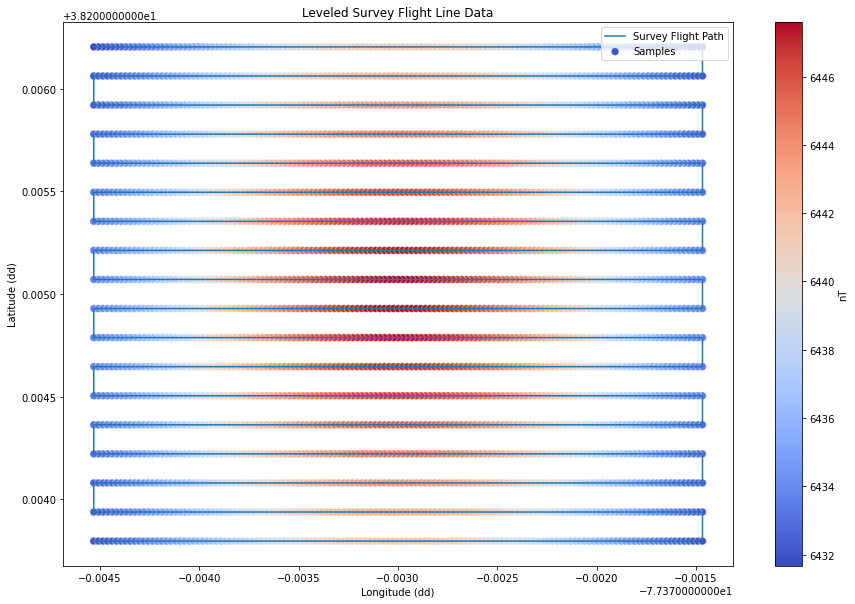

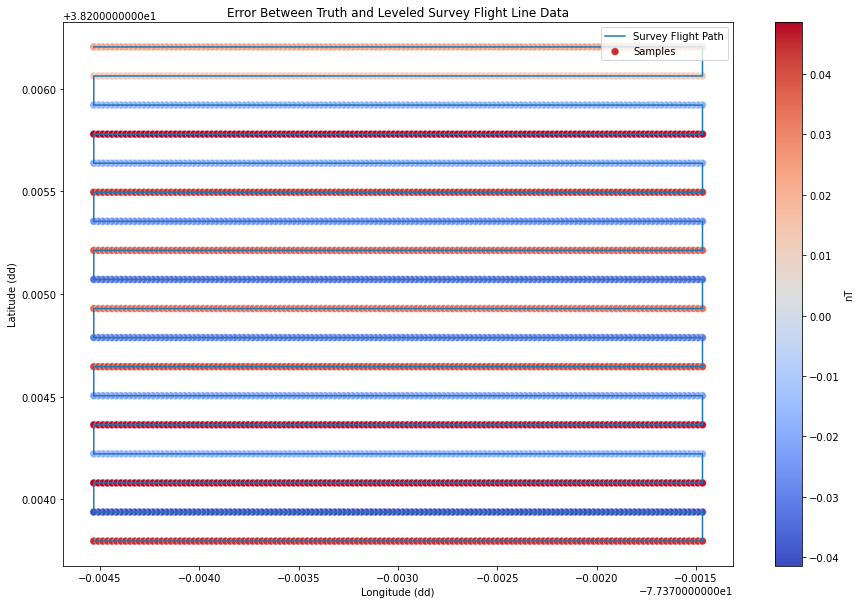

In [12]:
fl_mask        = survey_df.LINE_TYPE == 1
unique_fl_nums = np.unique(survey_df.LINE[fl_mask])
num_fls        = len(unique_fl_nums)
fl_scalar      = np.array(survey_df.F[fl_mask],    dtype=np.float64)
fl_lats        = np.array(survey_df.LAT[fl_mask],  dtype=np.float64)
fl_lons        = np.array(survey_df.LONG[fl_mask], dtype=np.float64)

tl_mask        = survey_df.LINE_TYPE == 0
unique_tl_nums = np.unique(survey_df.LINE[tl_mask])
num_tls        = len(unique_tl_nums)
tl_scalar      = np.array(survey_df.F[tl_mask],    dtype=np.float64)
tl_lats        = np.array(survey_df.LAT[tl_mask],  dtype=np.float64)
tl_lons        = np.array(survey_df.LONG[tl_mask], dtype=np.float64)

# Find intersection coordinates
num_ints = num_fls * num_tls
int_lats = np.zeros(num_ints)
int_lons = np.zeros(num_ints)

combinations = np.array(np.meshgrid(unique_fl_nums, unique_tl_nums)).T.reshape(-1, 2)

for i, combination in enumerate(combinations):
    fl, tl = combination
    
    int_fl_lats = survey_df.LAT[fl_mask & (survey_df.LINE == fl)]
    int_fl_lons = survey_df.LONG[fl_mask & (survey_df.LINE == fl)]
    
    int_tl_lats = survey_df.LAT[tl_mask & (survey_df.LINE == tl)]  + 0.0000000005
    int_tl_lons = survey_df.LONG[tl_mask & (survey_df.LINE == tl)] + 0.0000000005
    
    int_lat, int_lon = cu.path_intersection(int_fl_lats,
                                            int_fl_lons,
                                            int_tl_lats,
                                            int_tl_lons)
    
    int_lats[i] = int_lat
    int_lons[i] = int_lon

# Interpolate flight and tie lines at the intersection locations
interp_fl = interpolate.Rbf(fl_lons,
                            fl_lats,
                            fl_scalar,
                            function='linear')
fl_interp = interp_fl(int_lons, int_lats)

interp_tl = interpolate.Rbf(tl_lons,
                            tl_lats,
                            tl_scalar,
                            function='linear')
tl_interp = interp_tl(int_lons, int_lats)

# Find the difference between the flight line and interpolated flight line data
diff      = (fl_interp - tl_interp).reshape(num_fls, num_tls)
diff_lats = int_lats.reshape(num_fls, num_tls)
diff_lons = int_lons.reshape(num_fls, num_tls)

lvld_survey_df = deepcopy(survey_df)
lvld_survey_df['CORR'] = 0

# Find the first order line of best fit of the difference data
# for each flight line
for i, k in enumerate(range(diff.shape[0])):
    fl_num         = unique_fl_nums[i]
    fl_samp_mask   = (fl_mask) & (survey_df.LINE == fl_num)
    fl_samp_lats   = survey_df.LAT[fl_samp_mask]
    fl_samp_lons   = survey_df.LONG[fl_samp_mask]
    fl_samp_coords = np.hstack([np.array(fl_samp_lats)[:, np.newaxis],
                                np.array(fl_samp_lons)[:, np.newaxis]])
    ref_coord      = fl_samp_coords[0]
    fl_samp_dists  = distance.cdist(fl_samp_coords,
                                    [ref_coord],
                                    'euclidean').flatten()
    
    diff_line      = diff[k]
    diff_line_lats = diff_lats[k]
    diff_line_lons = diff_lons[k]
    diff_coords    = np.hstack([diff_line_lats[:, np.newaxis],
                                diff_line_lons[:, np.newaxis]])
    diff_dists     = distance.cdist(diff_coords,
                                    [ref_coord],
                                    'euclidean').flatten()
    
    res = stats.linregress(diff_dists, diff_line)
    
    corrections = res.intercept + (res.slope * fl_samp_dists)
    
    # Apply the leveling corrections for the given flight line
    lvld_survey_df['F'].loc[fl_samp_mask] = survey_df['F'].loc[fl_samp_mask] - corrections
    lvld_survey_df['CORR'].loc[fl_samp_mask] = corrections

lvld_fl_scalar = lvld_survey_df['F'].loc[fl_mask]
lvld_fl_corr   = lvld_survey_df['CORR'].loc[fl_mask]
    
plt.figure()
plt.title('True Survey Flight Line Data')
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.plot(fl_lons, fl_lats, label='Survey Flight Path')
cb = plt.scatter(fl_lons, fl_lats, s=60, c=truth_fl_scalar, edgecolor='#ffffff66', label='Samples', cmap=cm.coolwarm)
plt.colorbar(cb, label='nT')
plt.legend()

plt.figure()
plt.title('Unleveled Survey Flight Line Data')
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.plot(fl_lons, fl_lats, label='Survey Flight Path')
cb = plt.scatter(fl_lons, fl_lats, s=60, c=fl_scalar, edgecolor='#ffffff66', label='Samples', cmap=cm.coolwarm)
plt.colorbar(cb, label='nT')
plt.legend()

plt.figure()
plt.title('Flight Line Correction Data')
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.plot(fl_lons, fl_lats, label='Survey Flight Path')
cb = plt.scatter(fl_lons, fl_lats, s=60, c=lvld_fl_corr, edgecolor='#ffffff66', label='Samples', cmap=cm.coolwarm)
plt.colorbar(cb, label='nT')
plt.legend()

plt.figure()
plt.title('Leveled Survey Flight Line Data')
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.plot(fl_lons, fl_lats, label='Survey Flight Path')
cb = plt.scatter(fl_lons, fl_lats, s=60, c=lvld_fl_scalar, edgecolor='#ffffff66', label='Samples', cmap=cm.coolwarm)
plt.colorbar(cb, label='nT')
plt.legend()

plt.figure()
plt.title('Error Between Truth and Leveled Survey Flight Line Data')
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.plot(fl_lons, fl_lats, label='Survey Flight Path')
cb = plt.scatter(fl_lons, fl_lats, s=60, c=truth_fl_scalar - lvld_fl_scalar, edgecolor='#ffffff66', label='Samples', cmap=cm.coolwarm)
plt.colorbar(cb, label='nT')
plt.legend()

print(rmse(lvld_fl_scalar, truth_fl_scalar), 'nT')